### Bibliotecas

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow   
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

### Definições

In [2]:
diretorio_raiz = '/Volumes/MiniArmstro/Resultados/Processamento'
diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023'
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'
raster_poligono_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Rain_mask_Sao_Paulo.tif'
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True
corpos_agua = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_baciahidro/SIRGAS_SHP_baciahidro_polygon.shp'
massa_agua = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_hidrogramassadagua_2004/SIRGAS_MASSADAGUA.shp'

# Configurações iniciais do OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True

In [9]:
# Define o local de interesse
place = "São Paulo, Brazil"

# Baixa a rede direcionada para análise de mão única
G = ox.graph_from_place(place, network_type='drive', retain_all=True)

# Número total de nós (interseções)
num_nodes = len(G.nodes)

# Número total de arestas (segmentos direcionais)
num_edges = len(G.edges)

# Contar quantas arestas têm 'oneway=True'
oneway_edges = [1 for _, _, _, data in G.edges(keys=True, data=True) if data.get("oneway") is True]
num_oneway_edges = sum(oneway_edges)

# Percentual de vias com mão única
percent_oneway = (num_oneway_edges / num_edges) * 100

# Exibe os resultados
print(f"Nós (interseções): {num_nodes}")
print(f"Arestas totais: {num_edges}")
print(f"Arestas com mão única: {num_oneway_edges}")
print(f"Percentual de mão única: {percent_oneway:.2f}%")



Nós (interseções): 122104
Arestas totais: 302839
Arestas com mão única: 54515
Percentual de mão única: 18.00%


In [5]:
# 1. Carregar o shapefile das subprefeituras de São Paulo
# Substitua pelo caminho do seu shapefile
gdf_subs = gpd.read_file(subprefeituras_shp)

# Atribuir o CRS correto se estiver ausente
if gdf_subs.crs is None:
    gdf_subs.set_crs(epsg=31983, inplace=True)  # SIRGAS 2000 / UTM 23S

# Reprojetar para WGS 84 (usado pelo OSMnx)
gdf_subs = gdf_subs.to_crs(epsg=4326)

# Verificar nomes das colunas
# print(gdf_subs.columns)

# Substitua abaixo pelo nome correto da coluna de identificação
nome_coluna = 'sp_nome'  # Ex: 'NOME', 'SUBPREF', etc.

In [6]:
# Inicializar lista para resultados
estatisticas = []

# 2. Loop pelas subprefeituras para coletar estatísticas
for idx, row in tqdm(gdf_subs.iterrows(), total=len(gdf_subs), desc="Processando subprefeituras"):
    nome = row[nome_coluna] if nome_coluna in row else f'Subpref_{idx}'
    print(f"Processando: {nome}")

    poligono = row.geometry
    
    try:
        # Baixar rede viária motorizável do OSM
        grafo = ox.graph_from_polygon(poligono, network_type='drive')

        gdf_nodes, gdf_edges = ox.graph_to_gdfs(grafo)

        # Reprojetar geometria temporariamente para calcular área em m²
        poligono_proj = gpd.GeoSeries([poligono], crs=4326).to_crs(epsg=3857).iloc[0]
        area_km2 = poligono_proj.area / 1e6

        # Reprojetar arestas para calcular comprimento
        total_km = gdf_edges.to_crs(epsg=3857).length.sum() / 1000
        densidade_viaria = total_km / area_km2 if area_km2 > 0 else 0

        estatisticas.append({
            'subprefeitura': nome,
            'area_km2': area_km2,
            'num_nos': len(gdf_nodes),
            'num_arestas': len(gdf_edges),
            'km_lineares': total_km,
            'densidade_viaria': densidade_viaria
        })

    except Exception as e:
        print(f"Erro na subprefeitura {nome}: {e}")

# Criar DataFrame final
df_resultado = pd.DataFrame(estatisticas)

# Juntar com o GeoDataFrame original para o mapa temático
gdf_resultado = gdf_subs.merge(df_resultado, left_on=nome_coluna, right_on='subprefeitura')

Processando subprefeituras:   0%|          | 0/32 [00:00<?, ?it/s]

Processando: FREGUESIA-BRASILANDIA


Processando subprefeituras:   3%|▎         | 1/32 [00:06<03:22,  6.53s/it]

Processando: CASA VERDE-CACHOEIRINHA


Processando subprefeituras:   6%|▋         | 2/32 [00:12<02:57,  5.92s/it]

Processando: LAPA


Processando subprefeituras:   9%|▉         | 3/32 [00:18<03:04,  6.36s/it]

Processando: PERUS


Processando subprefeituras:  12%|█▎        | 4/32 [00:23<02:38,  5.65s/it]

Processando: SE


Processando subprefeituras:  16%|█▌        | 5/32 [00:28<02:21,  5.25s/it]

Processando: SANTANA-TUCURUVI


Processando subprefeituras:  19%|█▉        | 6/32 [00:34<02:27,  5.66s/it]

Processando: PINHEIROS


Processando subprefeituras:  22%|██▏       | 7/32 [00:39<02:20,  5.61s/it]

Processando: JACANA-TREMEMBE


Processando subprefeituras:  25%|██▌       | 8/32 [00:47<02:25,  6.06s/it]

Processando: VILA MARIA-VILA GUILHERME


Processando subprefeituras:  28%|██▊       | 9/32 [00:52<02:12,  5.78s/it]

Processando: MOOCA


Processando subprefeituras:  31%|███▏      | 10/32 [00:58<02:07,  5.80s/it]

Processando: IPIRANGA


Processando subprefeituras:  34%|███▍      | 11/32 [01:03<02:01,  5.78s/it]

Processando: VILA MARIANA


Processando subprefeituras:  38%|███▊      | 12/32 [01:08<01:51,  5.56s/it]

Processando: PENHA


Processando subprefeituras:  41%|████      | 13/32 [01:15<01:53,  5.98s/it]

Processando: ERMELINO MATARAZZO


Processando subprefeituras:  44%|████▍     | 14/32 [01:18<01:32,  5.15s/it]

Processando: SAO MIGUEL


Processando subprefeituras:  47%|████▋     | 15/32 [01:24<01:27,  5.16s/it]

Processando: ITAQUERA


Processando subprefeituras:  50%|█████     | 16/32 [01:32<01:36,  6.00s/it]

Processando: ARICANDUVA-FORMOSA-CARRAO


Processando subprefeituras:  53%|█████▎    | 17/32 [01:37<01:26,  5.74s/it]

Processando: SAO MATEUS


Processando subprefeituras:  56%|█████▋    | 18/32 [01:44<01:28,  6.30s/it]

Processando: VILA PRUDENTE


Processando subprefeituras:  59%|█████▉    | 19/32 [01:48<01:11,  5.52s/it]

Processando: SAPOPEMBA


Processando subprefeituras:  62%|██████▎   | 20/32 [01:52<01:00,  5.02s/it]

Processando: PARELHEIROS


Processando subprefeituras:  66%|██████▌   | 21/32 [02:01<01:07,  6.18s/it]

Processando: CAMPO LIMPO


Processando subprefeituras:  69%|██████▉   | 22/32 [02:10<01:09,  7.00s/it]

Processando: CAPELA DO SOCORRO


Processando subprefeituras:  72%|███████▏  | 23/32 [02:21<01:14,  8.23s/it]

Processando: CIDADE ADEMAR


Processando subprefeituras:  75%|███████▌  | 24/32 [02:26<00:57,  7.19s/it]

Processando: JABAQUARA


Processando subprefeituras:  78%|███████▊  | 25/32 [02:28<00:41,  5.91s/it]

Processando: SANTO AMARO


Processando subprefeituras:  81%|████████▏ | 26/32 [02:34<00:33,  5.66s/it]

Processando: ITAIM PAULISTA


Processando subprefeituras:  84%|████████▍ | 27/32 [02:38<00:26,  5.27s/it]

Processando: GUAIANASES


Processando subprefeituras:  88%|████████▊ | 28/32 [02:42<00:19,  4.87s/it]

Processando: CIDADE TIRADENTES


Processando subprefeituras:  91%|█████████ | 29/32 [02:45<00:12,  4.24s/it]

Processando: BUTANTA


Processando subprefeituras:  94%|█████████▍| 30/32 [02:54<00:11,  5.75s/it]

Processando: PIRITUBA-JARAGUA


Processando subprefeituras:  97%|█████████▋| 31/32 [03:02<00:06,  6.56s/it]

Processando: M BOI MIRIM


Processando subprefeituras: 100%|██████████| 32/32 [03:10<00:00,  5.94s/it]


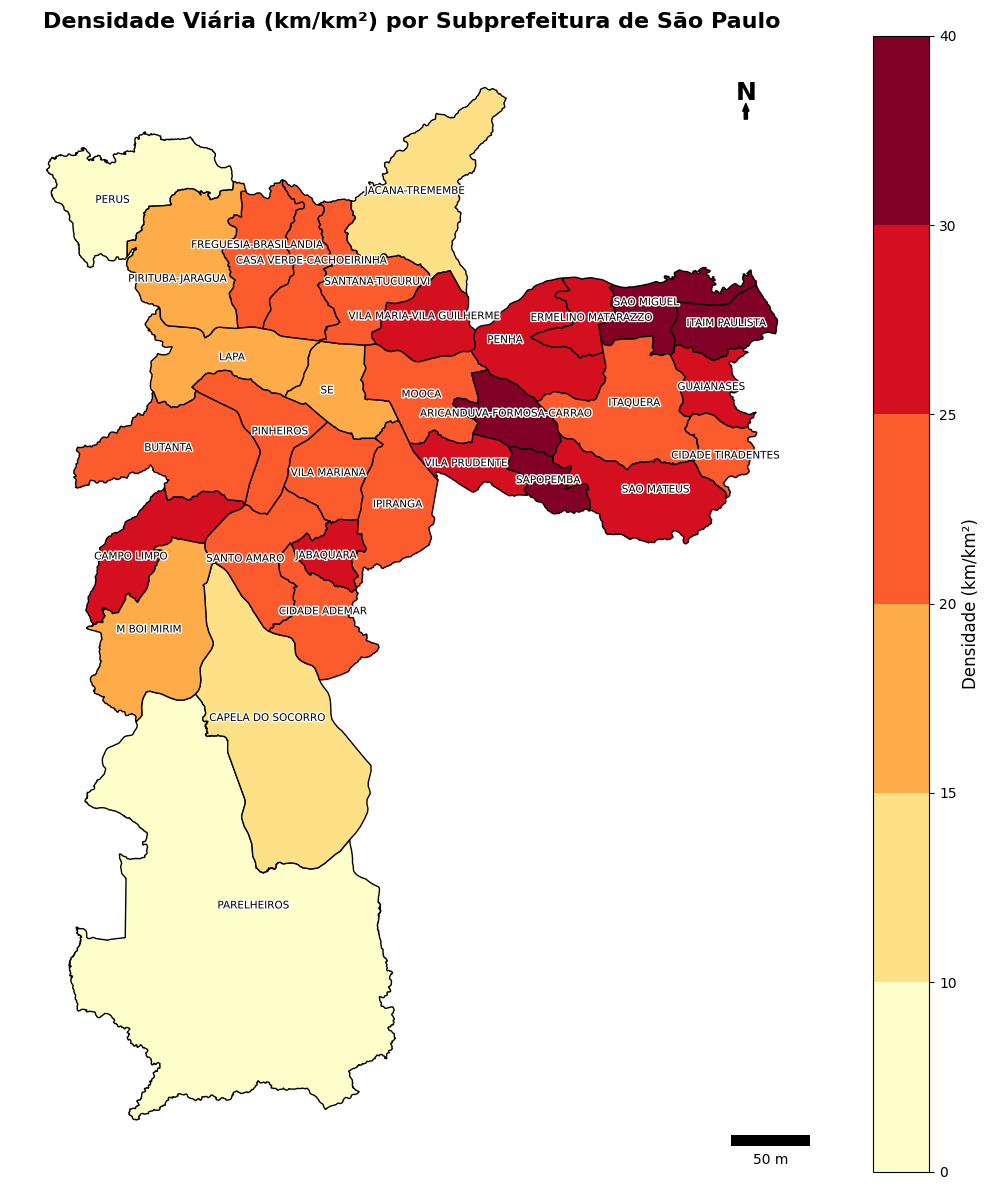

In [7]:
# 3. Mapa temático com a densidade viária

# Escolher paleta de cores mais contrastante
cmap_cores = 'YlOrRd'  # Outras opções: 'plasma', 'magma', 'cividis'
norm = Normalize(vmin=gdf_resultado['densidade_viaria'].min(), vmax=gdf_resultado['densidade_viaria'].max())

fig, ax = plt.subplots(figsize=(12, 12))

bins = [0, 10, 15, 20, 25, 30, 40]
norm = BoundaryNorm(bins, ncolors=256)

# Plot do mapa
gdf_resultado.plot(
    column='densidade_viaria',
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# Adicionar título
ax.set_title('Densidade Viária (km/km²) por Subprefeitura de São Paulo', fontsize=16, weight='bold')

ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),    # adicione outras que achar necessário
}

for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))  # usa deslocamento personalizado se existir
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=7.5, color='black',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    )


# Seta de norte com FancyArrow
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# Colorbar manual
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])  # necessário para a colorbar funcionar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Densidade (km/km²)', fontsize=12)

scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Remover eixos
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [ ]:
df_resiliencia = pd.read_csv('resiliencia_por_subprefeitura.csv')
#df_resiliencia.info()

# Calcular a mediana da resiliência por subprefeitura
df_mediana = df_resiliencia.groupby('Subprefeitura', as_index=False)['Resiliencia'].median()
df_mediana.rename(columns={'Resiliencia': 'mediana_resiliencia'}, inplace=True)

# Juntar com o GeoDataFrame contendo as geometrias
gdf_resultado = gdf_resultado.merge(df_mediana, left_on='subprefeitura', right_on='Subprefeitura', how='left')

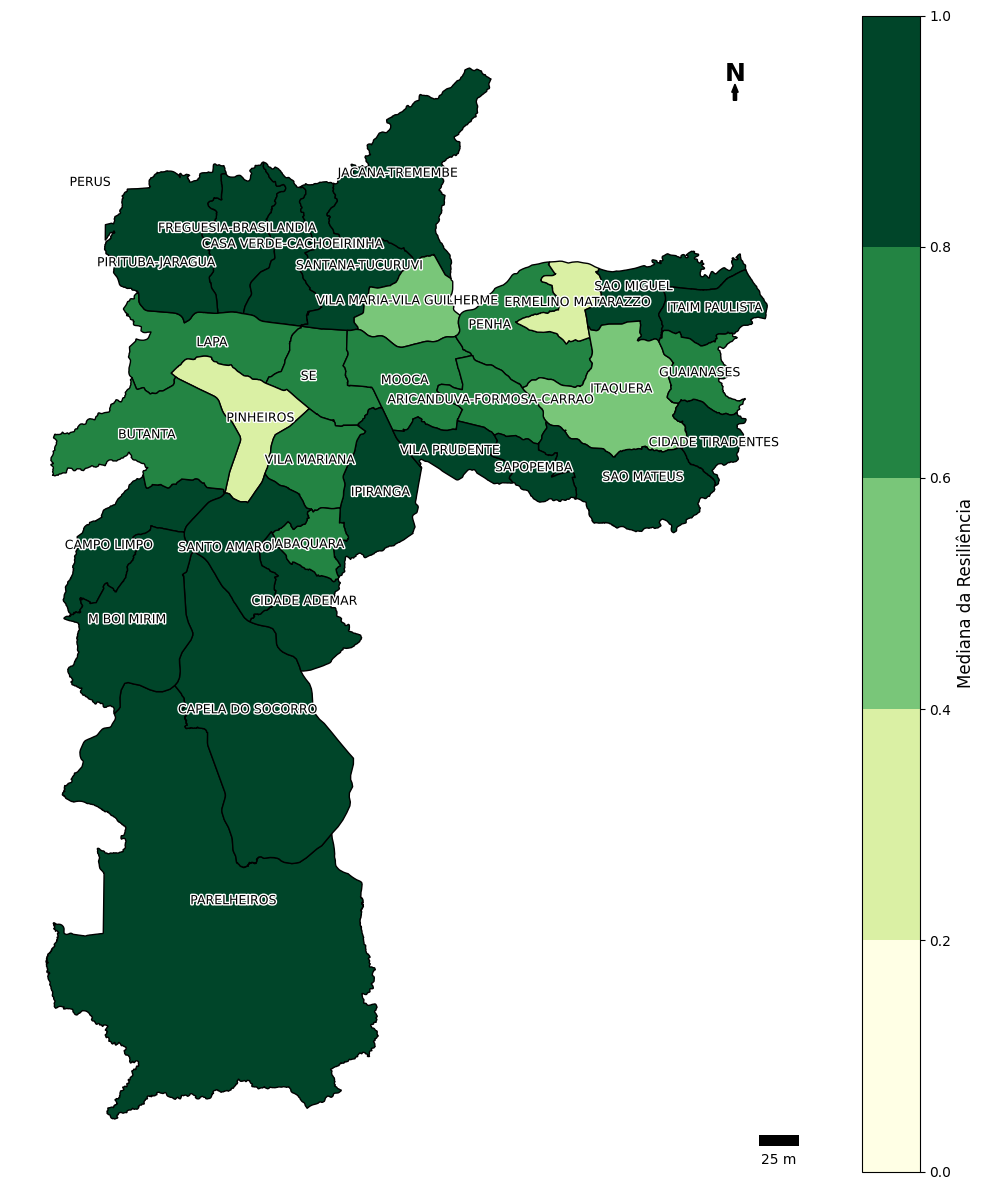

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'mediana_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'YlGn'  # ou 'viridis', 'plasma', etc.
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# TÍTULO
#ax.set_title('Mediana da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Mediana da Resiliência', fontsize=12)

# ESCALA
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [16]:
# Cálculo da amplitude da resiliência
df_amplitude = df_resiliencia.groupby('Subprefeitura', as_index=False)['Resiliencia'].agg(lambda x: x.max() - x.min())
df_amplitude.rename(columns={'Resiliencia': 'amplitude_resiliencia'}, inplace=True)

gdf_resultado = gdf_resultado.merge(df_amplitude, left_on='subprefeitura', right_on='Subprefeitura', how='left')


In [20]:
df_amplitude['amplitude_resiliencia'].describe()


count    31.000000
mean      0.208931
std       0.134111
min       0.030392
25%       0.116004
50%       0.172713
75%       0.256374
max       0.597600
Name: amplitude_resiliencia, dtype: float64

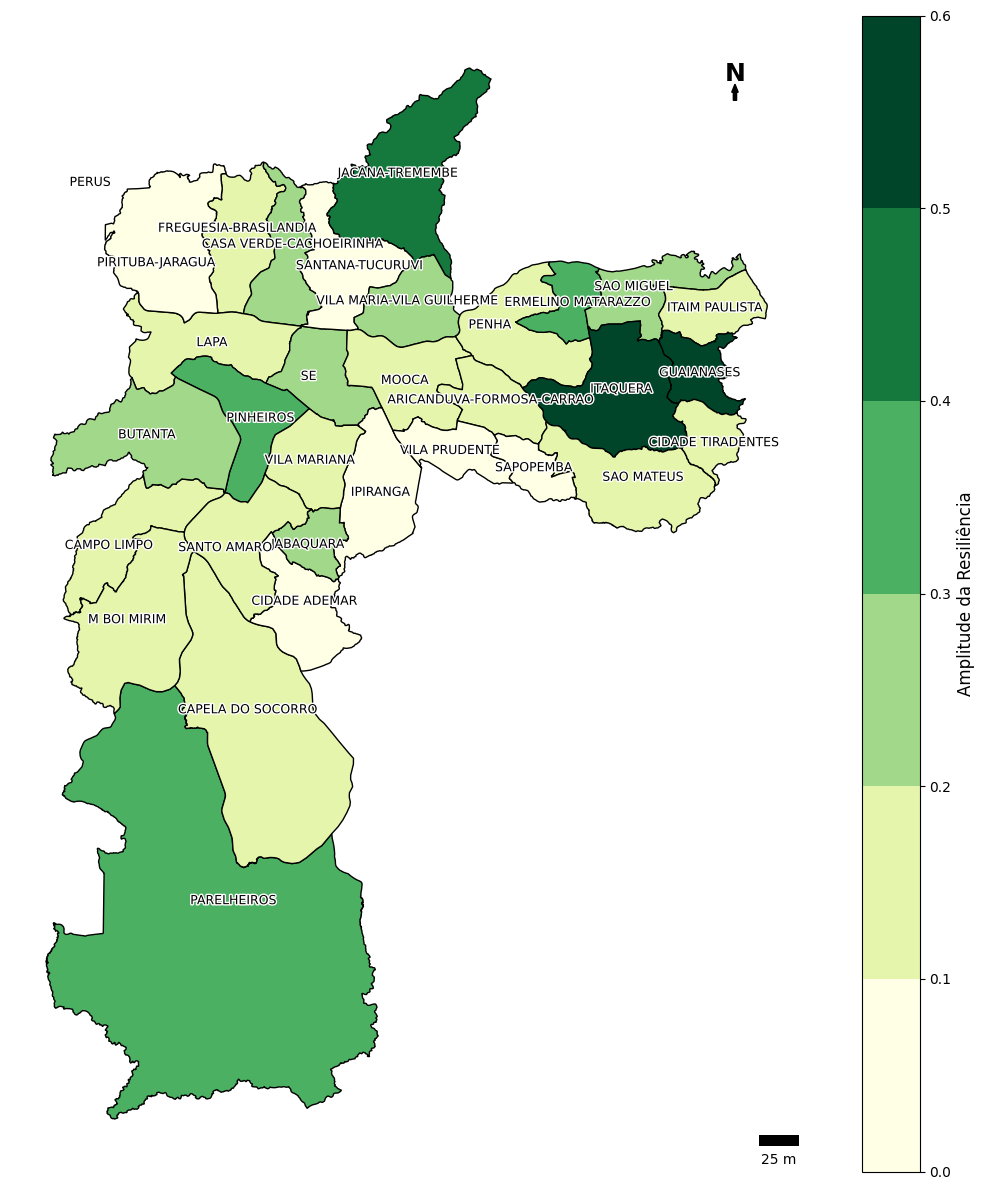

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'amplitude_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'YlGn'  # ou 'viridis', 'plasma', etc.
bins = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# TÍTULO
#ax.set_title('Amplitude da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Amplitude da Resiliência', fontsize=12)

# ESCALA
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


### Visualização das datas

In [19]:
arquivo_pacotes = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/pacotes.simul_2023_1120.xls'

In [14]:
# Ler a planilha usando o engine xlrd (necessário para arquivos .xls)
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

col_data = 'Data evento'  # Nome da coluna com a data do pacote
col_tipo = 'Tipo'  # Nome da coluna que indica se é 'Detalhado' ou 'Inteiro'

# Garantir formato datetime
df_real[col_data] = pd.to_datetime(df_real[col_data], errors='coerce')
df_real = df_real.dropna(subset=[col_data, col_tipo])

# 1. Garantir que a coluna de datas está em datetime
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors="coerce")

# 2. Filtrar apenas os meses desejados
df_real = df_real[
    df_real["Data evento"].dt.month.isin([1, 2, 3]) &
    (df_real["Data evento"].dt.year == 2023)
]

# 3. Mapear os tipos para códigos numéricos
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# 4. Atualizar o DataFrame de calendário com os dados reais
df_calendar["flood_code"] = df_calendar["date"].dt.date.map(flood_data_real).fillna(0).astype(int)

# Regerar o gráfico final com os dados reais integrados
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    month_df = df_calendar[df_calendar["month"] == month]

    # Pivot com preenchimento para alinhar altura
    pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="flood_code",
        aggfunc="first",
        fill_value=np.nan
    )
    day_pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="day",
        aggfunc="first",
        fill_value=np.nan
    )

    # Padding para igualar alturas
    while pivot.shape[0] < max_weeks:
        empty_row = pd.Series([np.nan] * 7, index=pivot.columns, name=pivot.index.max() + 1)
        pivot = pd.concat([pivot, empty_row.to_frame().T])
        day_pivot = pd.concat([day_pivot, empty_row.to_frame().T])

    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(pivot, cmap=cmap, vmin=0, vmax=2)

    ax.set_title(
        f'{month_names_pt[month]} 2023',
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    ax.set_xticks(range(7))
    ax.set_xticklabels(["S", "T", "Q", "Q", "S", "S", "D"])
    ax.set_yticks([])

    for y in range(pivot.shape[0]):
        for x in range(pivot.shape[1]):
            day_num = day_pivot.iloc[y, x]
            if not np.isnan(day_num):
                ax.text(x, y, str(int(day_num)), va='center', ha='center', fontsize=13, color='black')

    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="Sem alagamento"),
    Patch(facecolor=cmap(1), label="Simulação detalhada"),
    Patch(facecolor=cmap(2), label="Simulação inteira"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

#fig.suptitle("Alagamentos em Jan-Mar 2023", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'df_calendar' is not defined

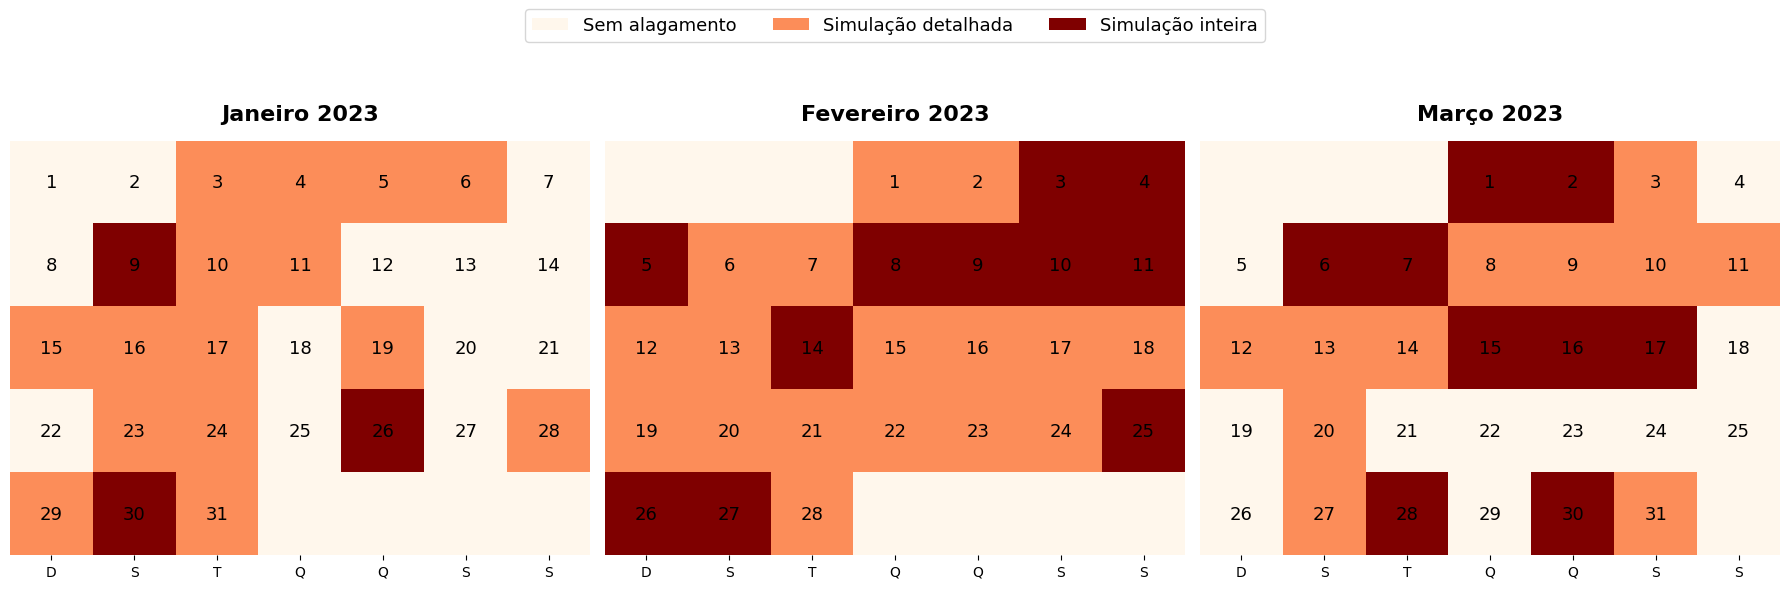

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib
import calendar

# Ler planilha
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

# Garantir datetime e remover nulos
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors='coerce')
df_real = df_real.dropna(subset=["Data evento", "Tipo"])

# Filtrar apenas jan, fev, mar de 2023
df_real = df_real[
    (df_real["Data evento"].dt.year == 2023) &
    (df_real["Data evento"].dt.month.isin([1, 2, 3]))
]

# Mapeamento de tipo
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# Parâmetros para plotagem
months = [1, 2, 3]
month_names_pt = {1: "Janeiro", 2: "Fevereiro", 3: "Março"}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]

    # Obter matriz de dias do calendário (semana x dia da semana)
    cal = calendar.Calendar(firstweekday=6)  # domingo = 0
    cal_matrix = cal.monthdayscalendar(2023, month)
    cal_matrix = np.array(cal_matrix)

    # Criar matriz de códigos (igual à matriz de dias)
    code_matrix = np.zeros_like(cal_matrix)

    for week_idx, week in enumerate(cal_matrix):
        for day_idx, day in enumerate(week):
            if day != 0:  # dia válido do mês
                date_obj = pd.Timestamp(year=2023, month=month, day=day).date()
                code_matrix[week_idx, day_idx] = flood_data_real.get(date_obj, 0)

    # Plotar imagem
    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(code_matrix, cmap=cmap, vmin=0, vmax=2)

    # Título do mês
    ax.set_title(
        f"{month_names_pt[month]} 2023",
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    # Eixos e labels
    ax.set_xticks(range(7))
    ax.set_xticklabels(["D", "S", "T", "Q", "Q", "S", "S"])  # Domingo primeiro
    ax.set_yticks([])

    # Inserir números dos dias
    for y in range(cal_matrix.shape[0]):
        for x in range(cal_matrix.shape[1]):
            day = cal_matrix[y, x]
            if day != 0:
                ax.text(x, y, str(day), va='center', ha='center', fontsize=13, color='black')

    # Remover bordas
    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="Sem alagamento"),
    Patch(facecolor=cmap(1), label="Simulação detalhada"),
    Patch(facecolor=cmap(2), label="Simulação inteira"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

plt.tight_layout()
plt.show()



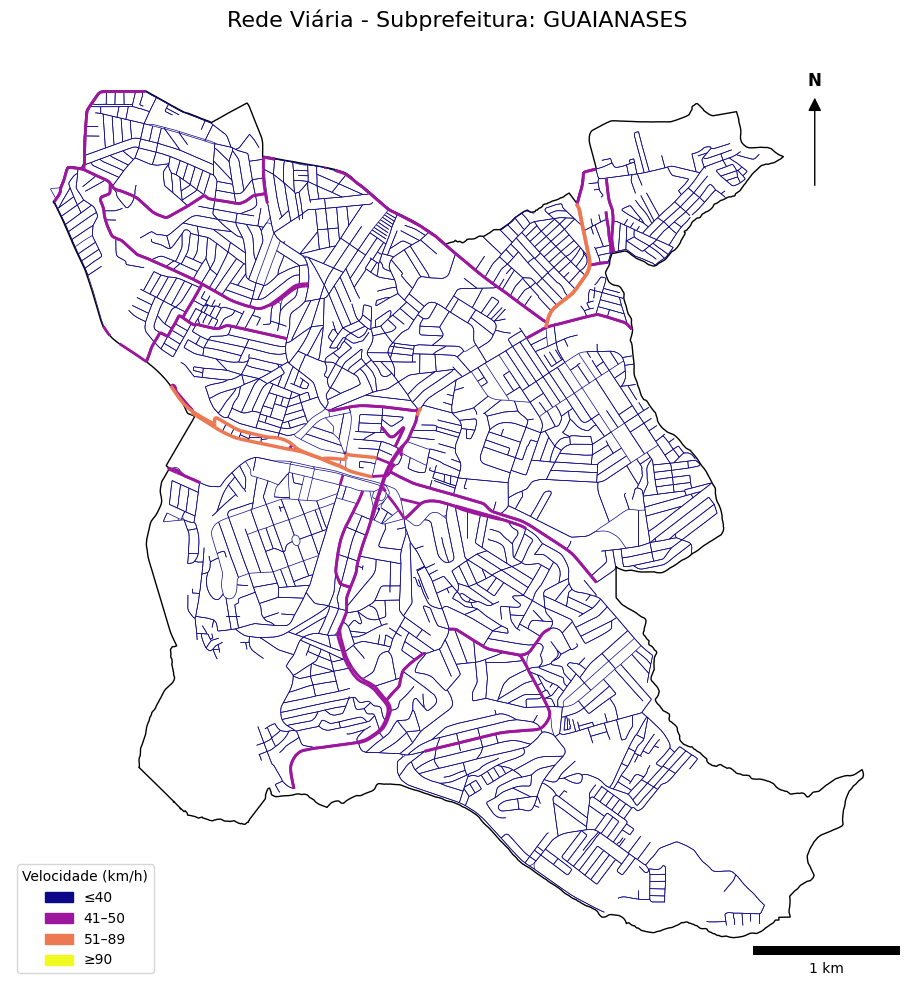

In [11]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib

# Parâmetros
nome_sub = 'GUAIANASES'

# Dados
gdf_subpref = gpd.read_file(subprefeituras_shp).set_crs("EPSG:31983")
gdf_sub = gdf_subpref[gdf_subpref['sp_nome'] == nome_sub]
gdf_sub_wgs84 = gdf_sub.to_crs("EPSG:4326")
poly_wgs84 = gdf_sub_wgs84.geometry.iloc[0]

# Rede viária
G = ox.graph_from_polygon(poly_wgs84, network_type="drive")
G = ox.add_edge_speeds(G, fallback=30)
nodes, edges = ox.graph_to_gdfs(G)
edges = edges.to_crs("EPSG:31983")

bins = [0, 40, 50, 89, float('inf')]
labels = ['≤40', '41–50', '51–89', '≥90']

edges['vel_classe'] = pd.cut(
    edges['speed_kph'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

espessuras = {
    '≤40': 0.5,
    '41–50': 2,
    '51–89': 2.5,
    '≥90': 3.5
}

# Criar cores automaticamente de um colormap
cmap = matplotlib.colormaps.get_cmap('plasma').resampled(len(labels))
cores = {label: cmap(i) for i, label in enumerate(labels)}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

for classe, cor in cores.items():
    subset = edges[edges['vel_classe'] == classe]
    if subset.empty:
        continue  # pula a classe vazia
    lw = espessuras.get(classe, 1)  # usa 1 como padrão se não encontrado
    subset.plot(ax=ax, color=cor, linewidth=lw, label=classe)

# Legenda manual
handles = [mpatches.Patch(color=cor, label=classe) for classe, cor in cores.items()]
leg = ax.legend(handles=handles, title="Velocidade (km/h)", loc='lower left', frameon=True)
leg.get_title().set_fontsize(10)

# Escala
scalebar = ScaleBar(dx=1, units="m", location="lower right")
ax.add_artist(scalebar)

# Seta de norte no canto superior direito
arrow = mpatches.FancyArrowPatch((0.9, 0.85), (0.9, 0.95), transform=ax.transAxes,
                                  color='black', arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arrow)
ax.text(0.9, 0.955, 'N', transform=ax.transAxes, ha='center', va='bottom',
        fontsize=12, fontweight='bold')

# Layout
ax.set_title(f"Rede Viária - Subprefeitura: {nome_sub}", fontsize=16, pad=15)
ax.set_axis_off()
plt.tight_layout()

# Exportar
plt.savefig(f"mapa_rede_viaria_{nome_sub.lower()}.png", dpi=300)
plt.show()


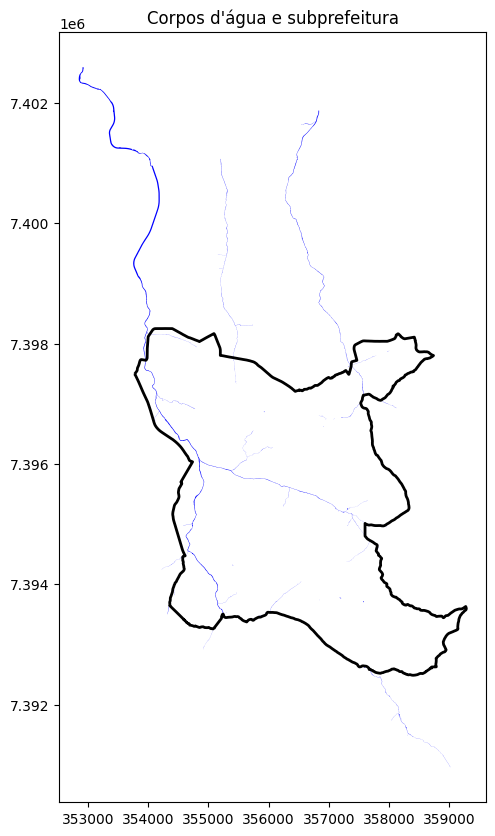

In [ ]:
import matplotlib.pyplot as plt

# Força o CRS apenas se tiver certeza de que o shapefile está em EPSG:31983
gdf_agua = gpd.read_file(massa_agua)
gdf_agua.set_crs("EPSG:31983", inplace=True)  # <- Define o CRS, não transforma

# Agora você pode converter (se necessário)
gdf_agua = gdf_agua.to_crs("EPSG:31983")  # Este passo é redundante se já está no CRS certo

# Certifique-se de que ambos estão no mesmo CRS
gdf_agua = gdf_agua.to_crs("EPSG:31983")
gdf_sub = gdf_sub.to_crs("EPSG:31983")

# Pega o polígono da subprefeitura
poligono = gdf_sub.geometry.iloc[0]

# Filtra os corpos d'água que estão dentro do polígono
gdf_agua_filtrado = gdf_agua[gdf_agua.geometry.intersects(poligono)]

fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.boundary.plot(ax=ax, color='black', linewidth=2)
gdf_agua_filtrado.plot(ax=ax, color='blue')
plt.title("Corpos d'água e subprefeitura")
plt.show()


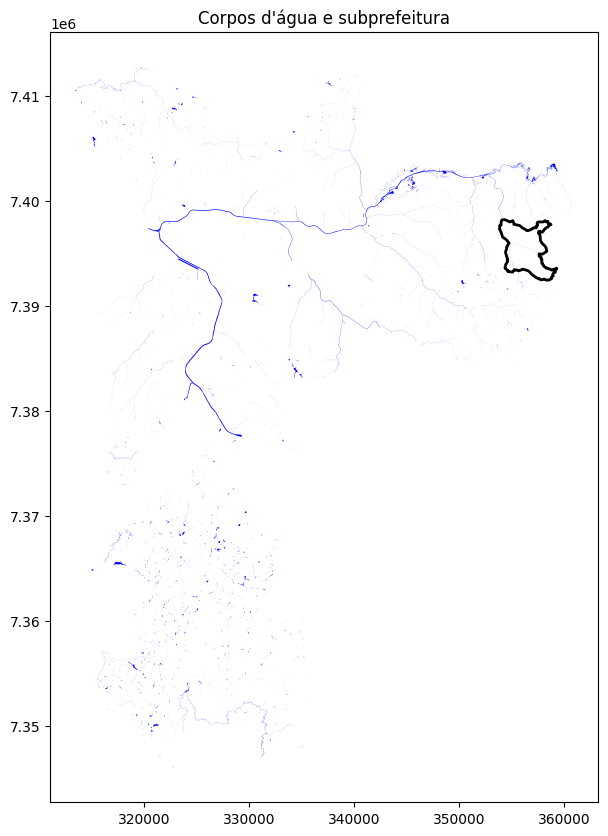

In [ ]:


fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.boundary.plot(ax=ax, color='black', linewidth=2)
gdf_agua.plot(ax=ax, color='blue')
plt.title("Corpos d'água e subprefeitura")
plt.show()


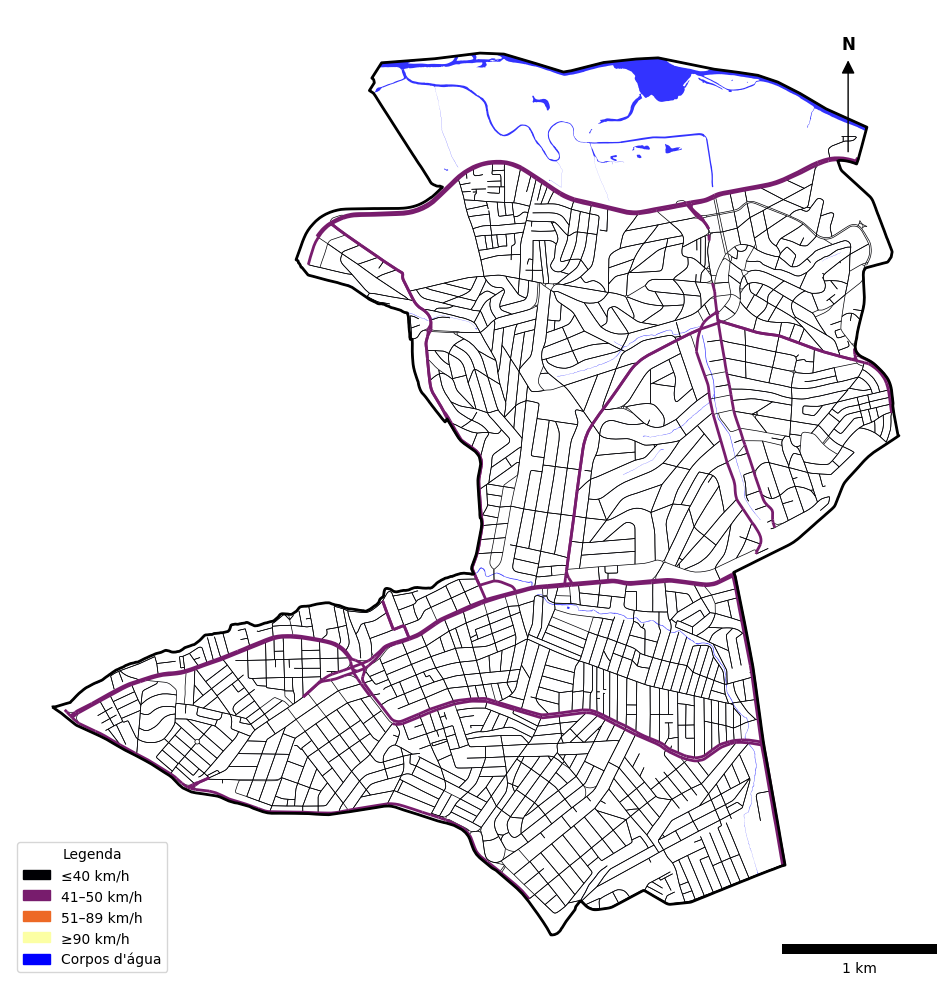

In [7]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from geopandas import clip

# Parâmetros
nome_sub = 'ERMELINO MATARAZZO'

# --- Dados de subprefeitura ---
gdf_subpref = gpd.read_file(subprefeituras_shp).set_crs("EPSG:31983")
gdf_sub = gdf_subpref[gdf_subpref['sp_nome'] == nome_sub]
gdf_sub_wgs84 = gdf_sub.to_crs("EPSG:4326")
poly_wgs84 = gdf_sub_wgs84.geometry.iloc[0]

# --- Rede viária ---
G = ox.graph_from_polygon(poly_wgs84, network_type="drive")
G = ox.add_edge_speeds(G, fallback=30)
nodes, edges = ox.graph_to_gdfs(G)
edges = edges.to_crs("EPSG:31983")

# Classificação de velocidade
bins = [0, 40, 50, 89, float('inf')]
labels = ['≤40 km/h', '41–50 km/h', '51–89 km/h', '≥90 km/h']
edges['vel_classe'] = pd.cut(edges['speed_kph'], bins=bins, labels=labels, include_lowest=True)

espessuras = {'≤40 km/h': 0.5, '41–50 km/h': 2, '51–89 km/h': 2.5, '≥90 km/h': 3.5}
cmap = matplotlib.colormaps.get_cmap('inferno').resampled(len(labels))
cores = {label: cmap(i) for i, label in enumerate(labels)}

# --- Corpos d'água ---
gdf_agua = gpd.read_file(massa_agua)
gdf_agua.set_crs("EPSG:31983", inplace=True)  # Define CRS se não existir
gdf_agua = gdf_agua.to_crs("EPSG:31983")
#gdf_agua_filtrado = gdf_agua[gdf_agua.geometry.intersects(gdf_sub.geometry.iloc[0])]
gdf_agua_filtrado = gpd.clip(gdf_agua, gdf_sub)

# --- Plotagem combinada ---
fig, ax = plt.subplots(figsize=(10, 10))

# Subprefeitura
gdf_sub.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
gdf_sub.boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=3)


# Corpos d’água
# gdf_agua_filtrado.plot(ax=ax, color='blue', linewidth=1, alpha=0.8, label='Corpos d\'água')

# Ex: rios maiores com espessura maior
for idx, row in gdf_agua_filtrado.iterrows():
    lw = 1.5 if row.get('waterway') == 'river' else 0.8
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color='blue', linewidth=lw, alpha=0.8)


# Rede viária
for classe, cor in cores.items():
    subset = edges[edges['vel_classe'] == classe]
    if subset.empty:
        continue
    lw = espessuras.get(classe, 1)
    subset.plot(ax=ax, color=cor, linewidth=lw, label=classe)

# Legenda
handles = [mpatches.Patch(color=cor, label=classe) for classe, cor in cores.items()]
handles.append(mpatches.Patch(color='blue', label="Corpos d'água"))
leg = ax.legend(handles=handles, title="Legenda", loc='lower left', frameon=True)
leg.get_title().set_fontsize(10)

# Escala
scalebar = ScaleBar(dx=1, units="m", location="lower right")
ax.add_artist(scalebar)

# Norte
arrow = mpatches.FancyArrowPatch((0.9, 0.85), (0.9, 0.95), transform=ax.transAxes,
                                  color='black', arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arrow)
ax.text(0.9, 0.955, 'N', transform=ax.transAxes, ha='center', va='bottom',
        fontsize=12, fontweight='bold')

# Layout final
#ax.set_title(f"Rede Viária e Corpos d'Água - Subprefeitura: {nome_sub}", fontsize=16, pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"mapa_viario_agua_{nome_sub.lower()}.png", dpi=300)
plt.show()
